In [45]:
# Consolidated imports and helper functions for density/LPP plots
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad

# Default parameters
gamma_sq = 0.25
eta = 1.0
theta = 2.0

# -- Helper functions shared by all plots --
def get_params(xi, gamma_sq, eta, theta):
    if -gamma_sq < xi <= 0:
        kappa = gamma_sq - abs(xi)
        nu = theta / eta
        m1 = 1.0 / kappa
        m2 = abs(xi) / kappa
        n1 = gamma_sq - 1.0
        n2 = abs(xi)
        prefactor_pow = eta
        prefactor_const = eta
    elif 0 < xi <= 1 - gamma_sq:
        kappa = gamma_sq
        nu = theta / eta
        m1 = 1.0 / kappa
        m2 = (theta * xi) / (eta * kappa)
        n1 = 0.0
        n2 = 1.0 - gamma_sq - xi
        prefactor_pow = eta
        prefactor_const = eta
    elif 1 - gamma_sq < xi < 1:
        kappa = 1.0 - xi
        nu = eta / theta
        m1 = 1.0 / kappa
        m2 = xi / kappa
        n1 = 1.0 - gamma_sq - xi
        n2 = 0.0
        prefactor_pow = theta
        prefactor_const = theta
    else:
        raise ValueError(f"xi={xi} out of valid range")
    return nu, m1, m2, n1, n2, prefactor_pow, prefactor_const


def compute_constants(nu, m1, m2, n1, n2):
    m1_tilde = m1 * (n2 - n1)
    denom = m1_tilde * nu + nu + m2 + 1
    term_pow = (m2 + 1) / denom
    c0 = ((m1_tilde * nu + nu + m2) * (term_pow**(1/nu + 1))) / (m2 + 1)
    c1 = (nu * (m1_tilde + 1) * (term_pow**(1/nu - 1))) / (denom**2)
    s0 = (1 + m2) / (nu * (1 + m1_tilde))
    D = np.sqrt(4 * c0 * c1 * nu + c1**2 * (nu - 1)**2)
    sa = - (nu - 1)/(2*nu) - D / (2 * nu * c1)
    sb = - (nu - 1)/(2*nu) + D / (2 * nu * c1)
    return c0, c1, s0, sa, sb


def J_func(s, c0, c1, nu):
    term = (1 + 1/s + 0j)**(1/nu)
    return (c1 * s + c0) * term


def solve_inverse_J(y, c0, c1, nu, sa, sb):
    s_guess = (sa + sb) / 2.0 - 0.1j
    def equations(vars):
        s_real, s_imag = vars
        s = s_real + 1j * s_imag
        val = J_func(s, c0, c1, nu)
        return [val.real - y, val.imag]
    s_sol = fsolve(equations, [s_guess.real, s_guess.imag])
    return s_sol[0] + 1j*s_sol[1]


def omega_density(y, nu, m1, m2, n1, n2):
    c0, c1, s0, sa, sb = compute_constants(nu, m1, m2, n1, n2)
    a_val = J_func(sa, c0, c1, nu).real
    b_val = J_func(sb, c0, c1, nu).real
    if y <= a_val or y >= b_val:
        return 0.0
    s = solve_inverse_J(y, c0, c1, nu, sa, sb)
    m1_tilde = m1 * (n2 - n1)
    prefactor = (m2 + 1) * (m1_tilde * nu + nu + m2 + 1) / (nu * (m1_tilde + 1) * np.pi * y)
    val = 1.0 / (s - s0)
    return prefactor * abs(val.imag)


def mu_density(x, xi, gamma_sq, eta, theta):
    try:
        nu, m1, m2, n1, n2, p_pow, p_const = get_params(xi, gamma_sq, eta, theta)
    except ValueError:
        return 0.0
    y = x**p_pow
    c0, c1, s0, sa, sb = compute_constants(nu, m1, m2, n1, n2)
    a_val = J_func(sa, c0, c1, nu).real
    b_val = J_func(sb, c0, c1, nu).real
    if y <= a_val or y >= b_val:
        return 0.0
    om = omega_density(y, nu, m1, m2, n1, n2)
    return p_const * (x**(p_const - 1)) * om


Computing grid values...


/var/folders/4v/x2xwrrtn4qlfxhk26rt_4k700000gn/T/ipykernel_6767/4251328142.py:71: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  s_sol = fsolve(equations, [s_guess.real, s_guess.imag])
/var/folders/4v/x2xwrrtn4qlfxhk26rt_4k700000gn/T/ipykernel_6767/4251328142.py:71: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  s_sol = fsolve(equations, [s_guess.real, s_guess.imag])


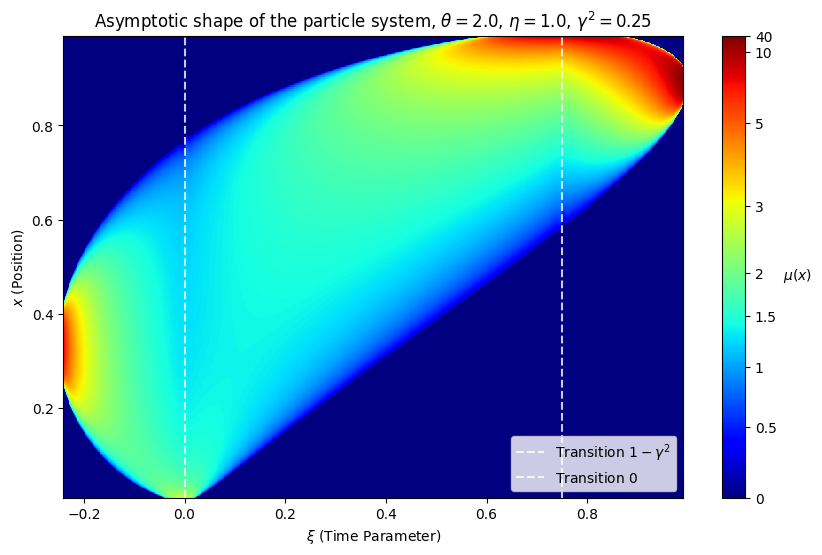

In [47]:
# RHP / grid heatmap (from RHP_min_new.py)
xi_res = 700
x_res = 700

xi_vals = np.linspace(-gamma_sq + 0.01, 0.99, xi_res)
x_vals = np.linspace(0.01, 0.99, x_res)
boundary = 1 - gamma_sq
xi_vals = xi_vals[np.abs(xi_vals - boundary) > 0.01]
xi_vals = xi_vals[np.abs(xi_vals) > 0.01]

X_grid, XI_grid = np.meshgrid(x_vals, xi_vals)
Z_grid = np.zeros_like(X_grid)

print("Computing grid values...")
for i in range(len(xi_vals)):
    xi = xi_vals[i]
    for j in range(len(x_vals)):
        x = x_vals[j]
        Z_grid[i, j] = mu_density(x, xi, gamma_sq, eta, theta)

# Transform for color mapping
scale_factor = 3.0
Z_transformed = 1 - np.exp(-Z_grid / scale_factor)

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(XI_grid, X_grid, Z_transformed, cmap='jet', shading='auto', vmin=0, vmax=1)
true_ticks = [0, 0.5, 1, 1.5, 2, 3, 5, 10, 40]
transformed_locs = [1 - np.exp(-v / scale_factor) for v in true_ticks]

cbar = plt.colorbar(mesh)
cbar.set_ticks(transformed_locs)
cbar.set_ticklabels([str(v) for v in true_ticks])
cbar.set_label(r'$\mu(x)$', rotation=360, labelpad=15)

plt.xlabel(r'$\xi$ (Time Parameter)')
plt.ylabel(r'$x$ (Position)')
plt.title(r'Asymptotic shape of the particle system, $\theta=%.1f$, $\eta=%.1f$, $\gamma^2=%.2f$' % (theta, eta, gamma_sq))
plt.axvline(x=1-gamma_sq, color='white', linestyle='--', alpha=0.8, label=r'Transition $1-\gamma^2$')
plt.axvline(x=0, color='white', linestyle='--', alpha=0.8, label=r'Transition $0$')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Plane partition / limit shape (from PlanePartition.py)
xi_res = 100
s_res = 100
s_max = 6.0

print("Computing Limit Shape Height Profile...")
xi_vals = np.linspace(-gamma_sq + 0.01, 0.99, xi_res)
boundary = 1 - gamma_sq
xi_vals = xi_vals[np.abs(xi_vals - boundary) > 0.02]
xi_vals = xi_vals[np.abs(xi_vals) > 0.02]

s_vals = np.linspace(0, s_max, s_res)
XI_grid, S_grid = np.meshgrid(xi_vals, s_vals)
Height_grid = np.zeros_like(XI_grid)

for i, xi in enumerate(xi_vals):
    for j, s in enumerate(s_vals):
        x_limit = np.exp(-s)
        val, _ = quad(mu_density, 0, x_limit, args=(xi, gamma_sq, eta, theta), limit=50)
        Height_grid[j, i] = min(max(val, 0.0), 1.0)

plt.figure(figsize=(10, 7))
mesh = plt.pcolormesh(XI_grid, S_grid, Height_grid, cmap='viridis', shading='auto', vmin=0, vmax=1)
cbar = plt.colorbar(mesh)
cbar.set_label(r'Height Profile (Filling Fraction)', rotation=270, labelpad=15)

xi_pos = np.linspace(0.01, 1, 100)
s_pos = -np.log(xi_pos)
mask_pos = (s_pos >= 0) & (s_pos <= s_max)
plt.plot(xi_pos[mask_pos], s_pos[mask_pos], color='cyan', linewidth=2, linestyle='--', label=r'$s = -\\ln(\\xi)$')

xi_neg = np.linspace(-gamma_sq, -0.01, 100)
s_neg = -np.log(-gamma_sq * xi_neg)
mask_neg = (s_neg >= 0) & (s_neg <= s_max)
plt.plot(xi_neg[mask_neg], s_neg[mask_neg], color='lime', linewidth=2, linestyle='--', label=r'$s = -\\ln(-\\gamma^2 \\xi)$')

plt.axvline(x=1-gamma_sq, color='white', linestyle='--', alpha=0.5, label=r'Transition $1-\\gamma^2$')
plt.axvline(x=0, color='white', linestyle='--', alpha=0.5, label=r'Transition $0$')

plt.xlabel(r'$\\xi$ (Time)')
plt.ylabel(r'$s$ (Length Coordinate)')
plt.title(r'Limit Shape of the Plane Partition (Heatmap)')
plt.legend(loc='upper right')
plt.xlim(-gamma_sq, 1)
plt.ylim(0, s_max)
plt.tight_layout()
plt.show()


Calculating density for xi = -0.1...
Calculating density for xi = 0.25...
Calculating density for xi = 0.9...


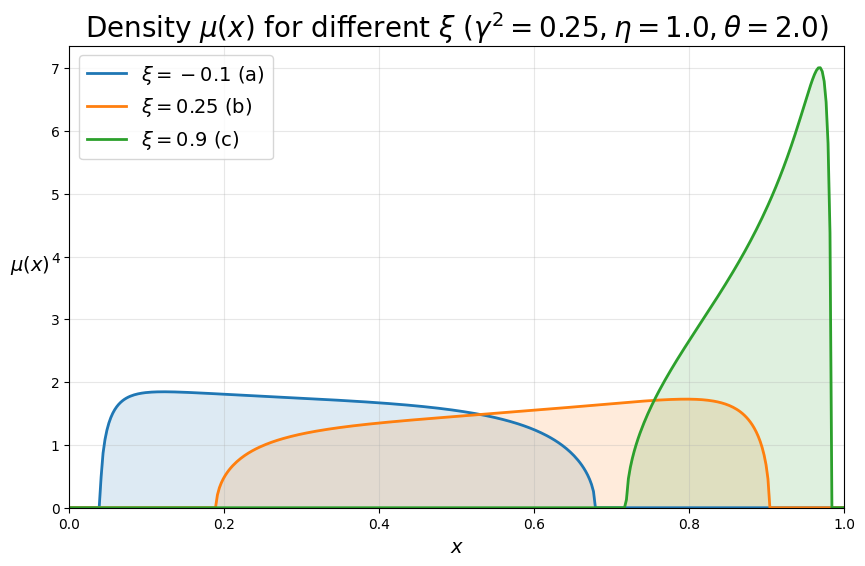

In [ ]:
# Density plot (from densityplot.py)
# Selected xi values for Regimes (a), (b), (c)
xi_values_to_plot = [-0.01, 0.25, 0.9]

plt.figure(figsize=(10, 6))

x_grid = np.linspace(0.001, 0.999, 400) # Grid for x-axis

for xi in xi_values_to_plot:
    print(f"Calculating density for xi = {xi}...")
    mu_vals = [mu_density(x, xi, gamma_sq, eta, theta) for x in x_grid]
    regime = ""
    if -gamma_sq < xi <= 0: regime = "(a)"
    elif 0 < xi <= 1 - gamma_sq: regime = "(b)"
    elif 1 - gamma_sq < xi < 1: regime = "(c)"
    line, = plt.plot(x_grid, mu_vals, linewidth=2, label=f'$\\xi={xi}$ {regime}')
    plt.fill_between(x_grid, mu_vals, color=line.get_color(), alpha=0.15)

plt.title(f'Density $\\mu(x)$ for different $\\xi$ ($\\gamma^2={gamma_sq}, \\eta={eta}, \\theta={theta}$)', size=20)
plt.xlabel('$x$', size=14)
plt.ylabel('$\\mu(x)$', rotation=0, labelpad=15,size=14)
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()
